# PHYS 555 Project 
Name: Mukesh Aryal

Student ID: V00977403

# Part 2

# Objective
Here, pretrained VGG16 model is imported and implored to solve our binary classfication problem. The feature layer including convolutional blocks are frozen and the last portion of the classfication layer is modified to adjust to the problem in hand. Freezing the feature layer prevents the model to adjust weights through back propagation in the feature layer. The classifier of the model, however, is allowed to train on the dataset as the require_gradient parameter of the classifier layer is set to true by default. The performance and accuracy of the model is then evaluated. 


In [ ]:
# importing libraries
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

# Getting the data 



In [ ]:
# getting the data
!wget -nc https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded 


--2022-04-11 22:22:52--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2022-04-11 22:22:53--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.109.216
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.109.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applic

# About the image dataset
The dataset contains chest x-ray images of normal people and people with Pneumonia. The images are not of uniform size. The dataset contains images labelled as normal, viral and bacterial cases but they are not sorted in particular folders. The dataset is only sorted into training and test folders by being grouped into two categories: NORMAL and PNEUMONIA. The dataset is imbalanced; hence, balancing is required. 

Chest X-ray images available were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. There are 5856 images. The dataset is also availabe in *Kaggle*. 

The features that separate three classes are regions of abnormal opacification. The opacification are caused by consolidation in lungs. When parts of the lungs are filled with some fluid, pus, blood or water, it is detected in x-ray images as white regions instead of usual dark segment of lungs. The dark regions in x-ray images of lungs signifies that the lungs are filled with air as it should be. 

For normal cases, there are no signs of abnormal opacification and the images show smooth dark region of lungs. For bacterial cases, images exhibit a *localized* segment of consolidation in either lobe of the lungs. The viral case differs from bacterial case as the images of this case show more *diffusive* interstitial pattern in both lungs. 

In [ ]:
# unzipping the files
# if the path already exists, upzipping is skipped! 

if not os.path.exists('chest_xray') :
  ! unzip -n file_downloaded
else:
  print("Files should already be unzipped.")

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person1562_bacteria_4078.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/P

In [ ]:
# Check the total number of images
folder_name = 'chest_xray'
all_files = glob.glob(folder_name+"/**/*.jpeg",recursive=True)
print(f"Total number of images: {len(all_files)}")

Total number of images: 5856


# Create balanced dataset of two classes for binary classification
Copying equal images into two folders: NORMAL and PNEUMONIA.
The PNEMONIA folder will have equal number of VIRAL and BACTERIAL cases.

In [ ]:
# Define helper functions to complete sorting images into new directories! 
def make_folder(category,folder_name):
  if not os.path.exists(folder_name+'/test/'+ category):
    os.makedirs(folder_name+'/test/'+ category)
  if not os.path.exists(folder_name+'/train/'+ category):
    os.makedirs(folder_name+'/train/'+ category)
  if not os.path.exists(folder_name+'/val/'+ category):
    os.makedirs(folder_name+'/val/'+ category)

def sort_to_folder(file,folder_name,count,train_lim, val_lim,test_lim,assign_to):
    count += 1
    if (count <= train_lim):
      shutil.copy(file,folder_name+"/train/"+ assign_to)
    elif((count > train_lim) & (count <= val_lim)):
      shutil.copy(file,folder_name+"/val/" + assign_to)
    elif((count > val_lim) & (count <= test_lim)):
      shutil.copy(file,folder_name+"/test/" + assign_to)
    return count

def print_num_of_files(class_name,folder_name):
  train_normal_dir = os.listdir(folder_name+"/train/"+ class_name)
  train_num = len(train_normal_dir)

  test_normal_dir = os.listdir(folder_name+"/test/" + class_name)
  test_num = len(test_normal_dir)

  val_normal_dir = os.listdir(folder_name+"/val/" + class_name)
  val_num = len(val_normal_dir)
  print(f"Number of {class_name} cases in the folder train: {train_num}, test: {test_num}, val: {val_num}")
  print("-"*100)
  return train_num, test_num, val_num

In [ ]:
#! rm -rf Balanced_data

# Making a new directories of balanced data for binary classification by copying the data from chest-xray

Equal number of viral and bacterial cases were included in the PNEUMONIA folder to check if the model can successfully distinguish them from normal cases. 

In [ ]:
# Set number of classes
num_classes = 2

# Make a new direction of Balanced data for binary classification by copying the data from chest-xray

# make new directories first
folder_name = "Balanced_data"
make_folder('NORMAL',folder_name)
make_folder('PNEUMONIA', folder_name)

# Copy balanced number of images to the folder
image_inside = glob.glob(folder_name+"/**/*.jpeg",recursive=True)
if (len(image_inside)==0):
  balance_train = 800
  balance_val = 800+100
  balance_test = 800+100+100
  data = []
  normal_count = 0
  viral_count = 0
  bact_count = 0
  for file in all_files:
    file_name = os.path.basename(file)
    if ('virus' in file_name):
      data.append([file,1])
      viral_count = sort_to_folder(file,folder_name, viral_count,balance_train/2,balance_val/2,balance_test/2,"PNEUMONIA")
      #print(viral_counter)
      
    elif('bacteria' in file_name):
      data.append([file,1])
      bact_count = sort_to_folder(file, folder_name, bact_count,balance_train/2,balance_val/2,balance_test/2,"PNEUMONIA")    
      
    else:
      data.append([file,0])
      normal_count = sort_to_folder(file,folder_name, normal_count, balance_train,balance_val,balance_test,"NORMAL")
else:
  print(f"Image file already present in the directory. Skipping sorting! The number of images present in the folder: {len(image_inside)}")

In [ ]:
# Check the number of images in each folder/class
norm_train_num, norm_test_num, norm_val_num = print_num_of_files("NORMAL",folder_name)
pneu_num, pneu_test_num, pneu_val_num = print_num_of_files("PNEUMONIA",folder_name)

Number of NORMAL cases in the folder train: 800, test: 100, val: 100
----------------------------------------------------------------------------------------------------
Number of PNEUMONIA cases in the folder train: 800, test: 100, val: 100
----------------------------------------------------------------------------------------------------


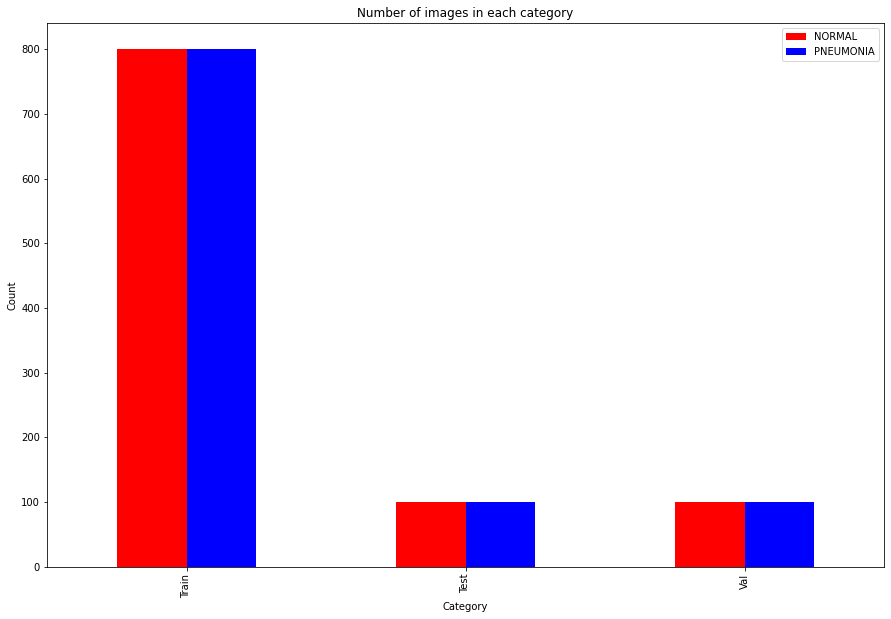

In [ ]:
# Visualizing the distribution of images in different classes!
df = pd.DataFrame({
    'NORMAL' : [norm_train_num, norm_test_num, norm_val_num],
    'PNEUMONIA': [pneu_num, pneu_test_num, pneu_val_num]},
    index = ['Train','Test','Val']
)

df.plot(kind = 'bar', stacked = False, color = ['red','blue'],figsize = (15,10))
plt.title("Number of images in each category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Importing torch and making necessary transforms. 

In [ ]:
# Importing torch and other necessary libraries

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}") 

Device: cpu


In [ ]:
train_dir = folder_name+"/train"
val_dir = folder_name+"/val"
test_dir = folder_name+"/test"

In [ ]:
# Define the transfer
trans = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [ ]:
train_set = ImageFolder(train_dir,trans)
val_set = ImageFolder(val_dir,trans)
test_set = ImageFolder(test_dir,trans)

In [ ]:
# make a quick check
img,label = train_set[200]
print(img.shape,label)
print(f"Images in training set: {len(train_set)}, images in val set: {len(val_set)}, images in test set: {len(test_set)}")

torch.Size([3, 64, 64]) 0
Images in training set: 1600, images in val set: 200, images in test set: 200


# Early stopping class
This class makes sure that we are not overfitting the model. It makes a checkpoint and saves the model everytime the validation loss is decreased as the training loss decreases. If validation loss starts increasing, insinuating overfitting, a counter records the times validation loss increases and stops the training process to avoid overfitting after reaching the patience limit. 


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Data loader 
batch_size = 64
train_loader = DataLoader(train_set,batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set,batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(val_set,batch_size = batch_size,shuffle = True)

# **Second Part!!**
# Transfer learning with VGG16

In [ ]:
# import the model and print it
import torchvision.models as models

# set the number of classes
num_classes = 2

model = models.vgg16(pretrained=True,progress=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freezing the Convolutional block and modifying the final layer of the classifier

model = models.vgg16(pretrained=True,progress=True)

for i in range(31):
  print(i)
  print(model.features[i])
  for param in (model.features[i].parameters()):
    param.requires_grad = False
  print("-"*50)

0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
--------------------------------------------------
1
ReLU(inplace=True)
--------------------------------------------------
2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
--------------------------------------------------
3
ReLU(inplace=True)
--------------------------------------------------
4
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
--------------------------------------------------
5
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
--------------------------------------------------
6
ReLU(inplace=True)
--------------------------------------------------
7
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
--------------------------------------------------
8
ReLU(inplace=True)
--------------------------------------------------
9
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
-----------------------------

In [ ]:
# Modifying the output of the classifier and specifying the loss function! 

model.classifier[6] = nn.Linear(4096,num_classes)

print(model)

lr_rate = 0.001

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = lr_rate)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Training function that includes early stopping

def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
n_epochs = 50
patience = 8

model, train_loss, valid_loss = train_model(model,batch_size,patience,n_epochs)

[ 1/50] train_loss: 1.33337 valid_loss: 0.80766
Validation loss decreased (inf --> 0.807665).  Saving model ...
[ 2/50] train_loss: 0.57342 valid_loss: 0.32918
Validation loss decreased (0.807665 --> 0.329176).  Saving model ...
[ 3/50] train_loss: 0.25663 valid_loss: 0.15787
Validation loss decreased (0.329176 --> 0.157866).  Saving model ...
[ 4/50] train_loss: 0.20417 valid_loss: 0.22664
EarlyStopping counter: 1 out of 8
[ 5/50] train_loss: 0.20250 valid_loss: 0.16250
EarlyStopping counter: 2 out of 8
[ 6/50] train_loss: 0.14151 valid_loss: 0.14486
Validation loss decreased (0.157866 --> 0.144862).  Saving model ...
[ 7/50] train_loss: 0.12024 valid_loss: 0.70763
EarlyStopping counter: 1 out of 8
[ 8/50] train_loss: 0.19169 valid_loss: 0.35998
EarlyStopping counter: 2 out of 8
[ 9/50] train_loss: 0.17727 valid_loss: 0.18212
EarlyStopping counter: 3 out of 8
[10/50] train_loss: 0.14453 valid_loss: 0.18669
EarlyStopping counter: 4 out of 8
[11/50] train_loss: 0.17295 valid_loss: 0.412

In [ ]:
# visualize the loss as the network trained
def plot_loss_vs_epoch():
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  #plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

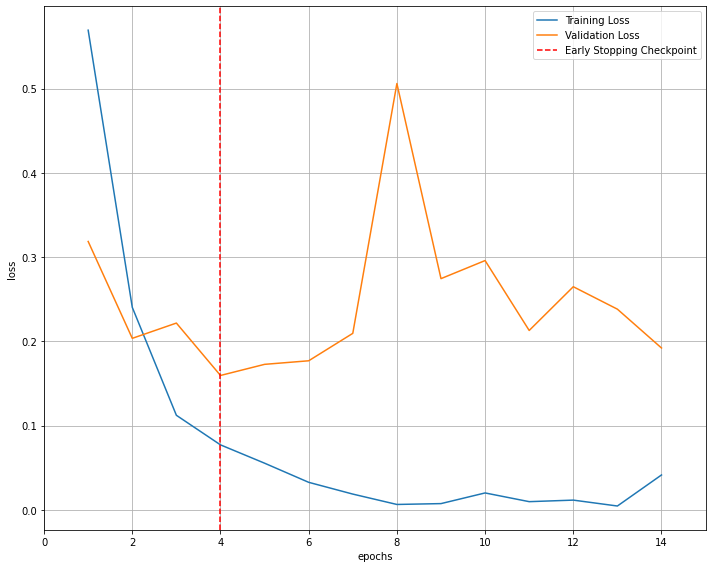

In [ ]:
plot_loss_vs_epoch()

In [ ]:
# Renaming label funtion for showing results:
def rename_label(label):
  if (num_classes == 2):
    if (label == 0):
      return "0|NORMAL"
    return "1|PNEUMONIA"
  else:
    if(label == 0):
      return "0|BACTERIAL"
    elif(label == 1):
      return "1|NORMAL"
  return "2|VIRAL"

# Test on the trained network

In [ ]:
from sklearn.metrics import confusion_matrix

def test_on_trained_network():
  # initialize lists to monitor test loss and accuracy
  pred_tot = []
  tar_tot = []
  test_loss = 0.0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))

  model.eval() # prep model for evaluation

  for data, target in test_loader:
      if len(target.data) != batch_size:
          break
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)

      # Addition for confusion matrix
      tar = (target.data.view_as(pred)).numpy()
      for ele in tar: tar_tot.append(rename_label(ele))
      for ele in pred: pred_tot.append(rename_label(ele))
      #

      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))


  # Build confusion matrix
  cf_matrix = confusion_matrix(tar_tot, pred_tot)
  plt.figure(figsize = (12,7))
  sns.heatmap(cf_matrix, annot=True)
  plt.xlabel("Predicted Class")
  plt.ylabel("Actual Class")
  plt.savefig('output.png')
  #

  #
  for i in range(num_classes):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              rename_label(i), 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy: N/A (no training examples)')

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.229827

Test Accuracy of 0|NORMAL: 94% (93/98)
Test Accuracy of 1|PNEUMONIA: 87% (82/94)

Test Accuracy (Overall): 91% (175/192)


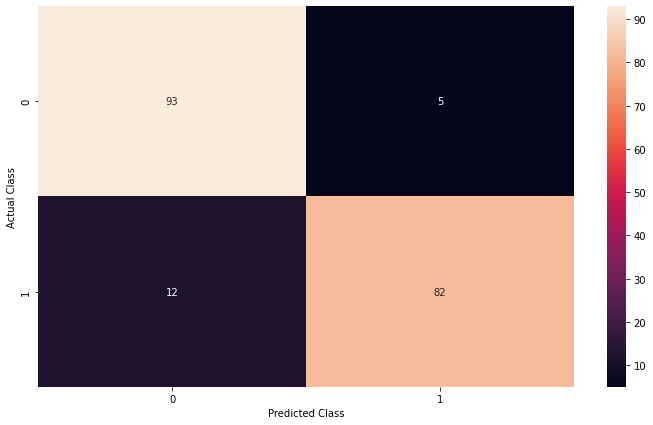

In [ ]:
# execute the test on trained network function
test_on_trained_network()

In [ ]:
# Functions for Visualizing the predictions

def visualize_result():
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds = torch.max(output, 1)
  # prep images for display
  images = images.numpy()

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 10))
  for idx in np.arange(10):
      print(images[idx].shape)
      ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
      ax.set_title("{} ({})".format(rename_label(preds[idx].item()), rename_label(labels[idx].item())),
                  color=("green" if preds[idx]==labels[idx] else "red"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)


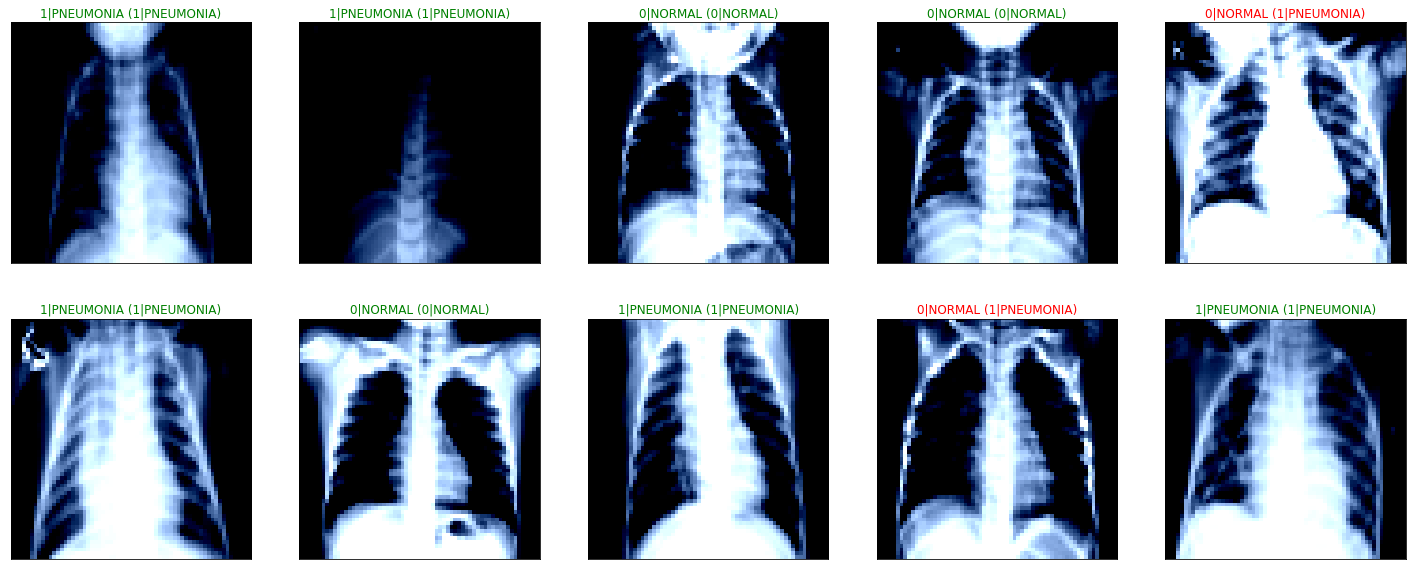

In [ ]:
# execute visualize the result
visualize_result()

# Remarks

The result from the pretrained model is very promising giving an **accuracy** of **91%** just by tweaking few parameters of the classifier. The model is easy to import and seems to work fine without tuning the parameters at all.

While comparing the result of VGG16 with a simple CNN model that I implemented, the accuracy of the simple model surpasses the accuracy obtained from the VGG model but it should be noted that the result was based on a single test run. The pre-trained model could easily have better performance with other test sets since it is a very powerful model. 

Being able to import a pretrained model and tweak its parameters to solve the problem is one of the coolest thing about transfer learning. 